In [34]:
#this is to auto-reload modules (like utils.py)
%load_ext autoreload
%autoreload 2
    
import os
import time
import sys
from datetime import datetime
from datetime import timedelta
from dateutil import relativedelta

#import warnings


sys.path.append('../') #needed to import utils.py

import utils

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import sklearn as sk

import seaborn as sns
plt.style.use('seaborn-whitegrid')

from statsmodels.graphics.gofplots import qqplot
import scipy.stats as stats

from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test

# Surpress warnings:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

%matplotlib inline  


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---
### Read data from `Demographic` and `ALS-History` csv file

##### Read pre-processed `Patient` CSV file

In [35]:
#set the data directory
data_dir = os.path.abspath('../03_proact_preprocessed/')

#set the name of CSV file
data_file = f'{data_dir}/_patient.csv'

#read data and show some info
df_main = pd.read_csv(data_file, delimiter=',')
df_main.head()

,subject_id,Age,Sex,Qty_Measurements_ALSFRS,Qty_Measurements_VITALSIGNS,Qty_Measurements_FVC,Qty_Measurements_SVC,Qty_Measurements_LABS,Qty_Measurements_HANDGRIPSTRENGTH,Qty_Measurements_MUSCLESTRENGTH,Qty_Measurements
0,329,38.0,Female,12.0,13.0,8.0,0.0,465.0,0.0,0.0,498.0
1,348,52.0,Female,15.0,10.0,0.0,9.0,820.0,0.0,0.0,854.0
2,533,65.0,Female,6.0,10.0,2.0,6.0,126.0,0.0,0.0,150.0
3,586,63.0,Male,1.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0
4,649,48.0,Female,12.0,12.0,12.0,0.0,420.0,0.0,0.0,456.0


##### Read RAW `ALS-History` CSV file and show some stats

In [36]:
#set the data directory
data_dir = os.path.abspath('../01_proact_raw_data_2022')

#set the name of CSV file
data_file = f'{data_dir}/PROACT_ALSHISTORY.csv'

#read data and show some info
df_raw = pd.read_csv(data_file, delimiter=',')

utils.show_columns_stats(df_raw) 

df_raw

subject_id..................... = 12936 rows (100.0%)     0 with NaN (  0.0%) Uniques= 10271 
Site_of_Onset___Bulbar......... =  1281 rows (  9.9%) 11655 with NaN ( 90.1%) Uniques=     3 
Site_of_Onset___Limb........... =  3589 rows (27.74%)  9347 with NaN (72.26%) Uniques=     3 
Site_of_Onset___Limb_and_Bulbar =     0 rows (  0.0%) 12936 with NaN (100.0%) Uniques=     1 
Site_of_Onset___Other.......... =     0 rows (  0.0%) 12936 with NaN (100.0%) Uniques=     1 
Site_of_Onset___Other_Specify.. =     0 rows (  0.0%) 12936 with NaN (100.0%) Uniques=     1 
Site_of_Onset___Spine.......... =     0 rows (  0.0%) 12936 with NaN (100.0%) Uniques=     1 
Subject_ALS_History_Delta...... =  9583 rows (74.08%)  3353 with NaN (25.92%) Uniques=     5 
Disease_Duration............... =     0 rows (  0.0%) 12936 with NaN (100.0%) Uniques=     1 
Symptom........................ =  2656 rows (20.53%) 10280 with NaN (79.47%) Uniques=    11 
Symptom_Other_Specify.......... =    50 rows ( 0.39%) 12886 

,subject_id,Site_of_Onset___Bulbar,Site_of_Onset___Limb,Site_of_Onset___Limb_and_Bulbar,Site_of_Onset___Other,Site_of_Onset___Other_Specify,Site_of_Onset___Spine,Subject_ALS_History_Delta,Disease_Duration,Symptom,Symptom_Other_Specify,Location,Location_Other_Specify,Site_of_Onset,Onset_Delta,Diagnosis_Delta
0,89,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,329,NaN,1.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,-1706.0,-1068.0
2,348,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Onset: Other,-501.0,-302.0
3,406,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,411,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12931,22564,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LOWER LIMB,NaN,Onset: Limb,-426.0,-67.0
12932,160135,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BULBAR,NaN,Onset: Bulbar,-651.0,-125.0
12933,304192,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LOWER LIMB,NaN,Onset: Limb,-838.0,-351.0
12934,820199,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UPPER LIMB,NaN,Onset: Limb,-155.0,-35.0


### Join the 2 datasets (renaming some columns if necessary)

NOTE: An ERROR occured due to `DeathData` has duplicate values in `subject_id` column

In [37]:
df = utils.join_datasets_by_key(
    df_main=df_main, 
    df_to_join=df_raw, 
    key_name='subject_id', 
    how='left',
    raise_error=True
)

# df.rename(columns={"Subject_Died": "event_dead", "Death_Days": "event_dead_days"}, inplace=True)

NameError: DF_TO_JOIN has duplicated values in KEY column. Remove duplicate keys before joining.

### Correct the duplicate `subject_id` problem in `RAW Data`


NOTE: apparently the reason for duplication `subject_id` values is because in #1 row was assigned the `Symptom` column, and the #2 row the `Onset_Delta` column

SOLUTION: group samples by `subject_id` column, and use `first()` function to get the first `non-NaN` value for each column

After merge values, 10,271 samples remained with no duplicated `subject_id`

In [38]:
df_als_history = df_raw.groupby(['subject_id']).first().reset_index()
df_als_history

,subject_id,Site_of_Onset___Bulbar,Site_of_Onset___Limb,Site_of_Onset___Limb_and_Bulbar,Site_of_Onset___Other,Site_of_Onset___Other_Specify,Site_of_Onset___Spine,Subject_ALS_History_Delta,Disease_Duration,Symptom,Symptom_Other_Specify,Location,Location_Other_Specify,Site_of_Onset,Onset_Delta,Diagnosis_Delta
0,89,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,NaN,None,NaN,NaN
1,329,NaN,1.0,NaN,NaN,NaN,NaN,0.0,NaN,None,None,None,NaN,None,-1706.0,-1068.0
2,348,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,None,None,None,NaN,Onset: Other,-501.0,-302.0
3,406,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,NaN,None,NaN,NaN
4,411,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,NaN,None,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10266,999823,0.0,1.0,NaN,NaN,NaN,NaN,0.0,NaN,None,None,None,NaN,None,-492.0,-84.0
10267,999863,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,NaN,None,NaN,NaN
10268,999880,NaN,1.0,NaN,NaN,NaN,NaN,0.0,NaN,None,None,None,NaN,None,-2865.0,-2105.0
10269,999929,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,None,None,None,NaN,Onset: Limb,-411.0,-107.0


##### Check if still exist samples with duplicated `subject_id` values

In [39]:
utils.get_duplicated_rows(df=df_als_history, column='subject_id')

,subject_id,Site_of_Onset___Bulbar,Site_of_Onset___Limb,Site_of_Onset___Limb_and_Bulbar,Site_of_Onset___Other,Site_of_Onset___Other_Specify,Site_of_Onset___Spine,Subject_ALS_History_Delta,Disease_Duration,Symptom,Symptom_Other_Specify,Location,Location_Other_Specify,Site_of_Onset,Onset_Delta,Diagnosis_Delta


----
----
----
# Pre-process the ALS-History data

### Create a new column called `site_onset` with the aim of standardize its values 
### to (`Limb`, `Bulbar`, `Spine`, `Limb and Bulbar`, and `Other`)

In [40]:
df_als_history['site_onset'] = np.NaN
df_als_history.head(3)

,subject_id,Site_of_Onset___Bulbar,Site_of_Onset___Limb,Site_of_Onset___Limb_and_Bulbar,Site_of_Onset___Other,Site_of_Onset___Other_Specify,Site_of_Onset___Spine,Subject_ALS_History_Delta,Disease_Duration,Symptom,Symptom_Other_Specify,Location,Location_Other_Specify,Site_of_Onset,Onset_Delta,Diagnosis_Delta,site_onset
0,89,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,NaN,None,NaN,NaN,NaN
1,329,NaN,1.0,NaN,NaN,NaN,NaN,0.0,NaN,None,None,None,NaN,None,-1706.0,-1068.0,NaN
2,348,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,None,None,None,NaN,Onset: Other,-501.0,-302.0,NaN


### Set value to `NaN` value for some columns where their values were different of `1`

In [41]:
columns = ['Site_of_Onset___Bulbar',
        'Site_of_Onset___Limb',
        'Site_of_Onset___Limb_and_Bulbar',
        'Site_of_Onset___Other',
        'Site_of_Onset___Other_Specify',
        'Site_of_Onset___Spine']
        

for col in columns:
    df_als_history.loc[(df_als_history[col] != 1), col] = np.NaN
    
df_als_history    

,subject_id,Site_of_Onset___Bulbar,Site_of_Onset___Limb,Site_of_Onset___Limb_and_Bulbar,Site_of_Onset___Other,Site_of_Onset___Other_Specify,Site_of_Onset___Spine,Subject_ALS_History_Delta,Disease_Duration,Symptom,Symptom_Other_Specify,Location,Location_Other_Specify,Site_of_Onset,Onset_Delta,Diagnosis_Delta,site_onset
0,89,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,NaN,None,NaN,NaN,NaN
1,329,NaN,1.0,NaN,NaN,NaN,NaN,0.0,NaN,None,None,None,NaN,None,-1706.0,-1068.0,NaN
2,348,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,None,None,None,NaN,Onset: Other,-501.0,-302.0,NaN
3,406,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,NaN,None,NaN,NaN,NaN
4,411,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,NaN,None,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10266,999823,NaN,1.0,NaN,NaN,NaN,NaN,0.0,NaN,None,None,None,NaN,None,-492.0,-84.0,NaN
10267,999863,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,NaN,None,NaN,NaN,NaN
10268,999880,NaN,1.0,NaN,NaN,NaN,NaN,0.0,NaN,None,None,None,NaN,None,-2865.0,-2105.0,NaN
10269,999929,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,None,None,None,NaN,Onset: Limb,-411.0,-107.0,NaN


### 1) Set column `site_onset` for BULBAR onset samples

##### Update samples with `Site_of_Onset`  = `"Onset: Bulbar"`

In [42]:
df_als_history.loc[(df_als_history['Site_of_Onset']=='Onset: Bulbar'), 'site_onset'] = 'Bulbar'
#df_als_history

##### Update samples with `Site_of_Onset___Bulbar`  = `1`

In [43]:
df_als_history.loc[
(df_als_history['Site_of_Onset___Bulbar']==1)
&(df_als_history['Site_of_Onset'].isnull()==True)
&(df_als_history['Site_of_Onset___Limb'].isnull()==True)
&(df_als_history['Site_of_Onset___Spine'].isnull()==True)
&(df_als_history['Site_of_Onset___Limb_and_Bulbar'].isnull()==True)
&(df_als_history['Site_of_Onset___Other'].isnull()==True)
&(df_als_history['Site_of_Onset___Other_Specify'].isnull()==True)
, 'site_onset'] = 'Bulbar' 

#df_als_history

### 2) Set column `site_onset` for LIMB / SPINAL onset samples

##### Update samples with `Site_of_Onset`  = `"Onset: Limb"` or `"Onset: Spine"`

In [44]:
df_als_history.loc[
    (df_als_history['Site_of_Onset']=='Onset: Limb')
    | (df_als_history['Site_of_Onset']=='Onset: Spine'), 'site_onset'] = 'Limb/Spinal'


#df_als_history

##### Update samples with `Site_of_Onset___Limb`  = `1` OR `Site_of_Onset___Spine`  = `1`  

In [45]:
#update samples with 'Site_of_Onset___Limb' = 1
df_als_history.loc[
(df_als_history['Site_of_Onset___Limb']==1)
&(df_als_history['Site_of_Onset___Bulbar'         ].isnull()==True)
&(df_als_history['Site_of_Onset'                  ].isnull()==True)
&(df_als_history['Site_of_Onset___Spine'          ].isnull()==True)
&(df_als_history['Site_of_Onset___Limb_and_Bulbar'].isnull()==True)
&(df_als_history['Site_of_Onset___Other'          ].isnull()==True)
&(df_als_history['Site_of_Onset___Other_Specify'  ].isnull()==True)
, 'site_onset'] = 'Limb/Spinal' 


#update samples with 'Site_of_Onset___Spine' = 1
df_als_history.loc[
 (df_als_history['Site_of_Onset___Spine']==1)
&(df_als_history['Site_of_Onset___Limb'           ].isnull()==True)
&(df_als_history['Site_of_Onset___Bulbar'         ].isnull()==True)
&(df_als_history['Site_of_Onset'                  ].isnull()==True)
&(df_als_history['Site_of_Onset___Limb_and_Bulbar'].isnull()==True)
&(df_als_history['Site_of_Onset___Other'          ].isnull()==True)
&(df_als_history['Site_of_Onset___Other_Specify'  ].isnull()==True)
, 'site_onset'] = 'Limb/Spinal' 


#df_als_history

### 3) Set column `site_onset` for "Bulbar and Limb/Spine" onset samples

##### Update samples with `Site_of_Onset`  = `"Onset: Limb and Bulbar"`

In [46]:
df_als_history.loc[
    (df_als_history['Site_of_Onset']=='Onset: Limb and Bulbar')
 , 'site_onset'] = 'Bulbar and Limb/Spinal'


#df_als_history

##### Update samples with `Site_of_Onset___Limb_and_Bulbar`  = `1`

In [47]:
df_als_history.loc[
 (df_als_history['Site_of_Onset___Limb_and_Bulbar']==1)
&(df_als_history['Site_of_Onset___Limb'           ].isnull()==True)
&(df_als_history['Site_of_Onset___Bulbar'         ].isnull()==True)
&(df_als_history['Site_of_Onset'                  ].isnull()==True)
&(df_als_history['Site_of_Onset___Spine'          ].isnull()==True)
&(df_als_history['Site_of_Onset___Other'          ].isnull()==True)
&(df_als_history['Site_of_Onset___Other_Specify'  ].isnull()==True)
, 'site_onset'] = 'Onset: Limb and Bulbar' 



#df_als_history

### 4) Set column `site_onset` for "Other" onset samples

##### Update samples with `Site_of_Onset`  = `"Onset: Other"`

In [48]:
df_als_history.loc[
    (df_als_history['Site_of_Onset']=='Onset: Other')
 , 'site_onset'] = 'Other'

#df_als_history

##### Update samples with `Site_of_Onset___Other`  = `1` OR `Site_of_Onset___Other_Specify`  = `1` 

In [49]:
#update samples with 'Site_of_Onset___Other' = 1
df_als_history.loc[
 (df_als_history['Site_of_Onset___Other'          ]==1)
&(df_als_history['Site_of_Onset___Other_Specify'  ].isnull()==True)
&(df_als_history['Site_of_Onset___Limb_and_Bulbar'].isnull()==True)
&(df_als_history['Site_of_Onset___Limb'           ].isnull()==True)
&(df_als_history['Site_of_Onset___Bulbar'         ].isnull()==True)
&(df_als_history['Site_of_Onset'                  ].isnull()==True)
&(df_als_history['Site_of_Onset___Spine'          ].isnull()==True)
 , 'site_onset'] = 'Other'

#update samples with 'Site_of_Onset___Other_Specify' = 1
df_als_history.loc[
 (df_als_history['Site_of_Onset___Other_Specify'  ]==1)
&(df_als_history['Site_of_Onset___Other'          ].isnull()==True)
&(df_als_history['Site_of_Onset___Limb_and_Bulbar'].isnull()==True)
&(df_als_history['Site_of_Onset___Limb'           ].isnull()==True)
&(df_als_history['Site_of_Onset___Bulbar'         ].isnull()==True)
&(df_als_history['Site_of_Onset'                  ].isnull()==True)
&(df_als_history['Site_of_Onset___Spine'          ].isnull()==True)
 , 'site_onset'] = 'Other'

#df_als_history

# Try to join the datasets again (renaming some columns if necessary)

In [50]:
df = utils.join_datasets_by_key(df_main=df_main, df_to_join=df_als_history, key_name='subject_id', how='left')

df.rename(columns={'Onset_Delta': 'Symptoms_Onset_Delta', 
                   'site_onset': 'Site_Onset'}, 
          inplace=True)

print(utils.get_quantity_of_rows(df_main))
print(utils.get_quantity_of_rows(df_als_history))
print(utils.get_quantity_of_rows(df))
df

7712
10271
7712


,subject_id,Age,Sex,Qty_Measurements_ALSFRS,Qty_Measurements_VITALSIGNS,Qty_Measurements_FVC,Qty_Measurements_SVC,Qty_Measurements_LABS,Qty_Measurements_HANDGRIPSTRENGTH,Qty_Measurements_MUSCLESTRENGTH,...,Subject_ALS_History_Delta,Disease_Duration,Symptom,Symptom_Other_Specify,Location,Location_Other_Specify,Site_of_Onset,Symptoms_Onset_Delta,Diagnosis_Delta,Site_Onset
0,329,38.0,Female,12.0,13.0,8.0,0.0,465.0,0.0,0.0,...,0.0,NaN,None,None,None,NaN,None,-1706.0,-1068.0,Limb/Spinal
1,348,52.0,Female,15.0,10.0,0.0,9.0,820.0,0.0,0.0,...,0.0,NaN,None,None,None,NaN,Onset: Other,-501.0,-302.0,Other
2,533,65.0,Female,6.0,10.0,2.0,6.0,126.0,0.0,0.0,...,0.0,NaN,None,None,None,NaN,None,-1023.0,-44.0,Bulbar
3,586,63.0,Male,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,NaN,None,None,None,NaN,Onset: Bulbar,-715.0,-507.0,Bulbar
4,649,48.0,Female,12.0,12.0,12.0,0.0,420.0,0.0,0.0,...,0.0,NaN,Weakness,None,FACIAL,NaN,Onset: Bulbar,-341.0,NaN,Bulbar
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7707,22564,63.0,Male,7.0,0.0,0.0,7.0,376.0,14.0,201.0,...,NaN,NaN,None,None,LOWER LIMB,NaN,Onset: Limb,-426.0,-67.0,Limb/Spinal
7708,160135,67.0,Female,7.0,0.0,0.0,6.0,365.0,14.0,189.0,...,NaN,NaN,None,None,BULBAR,NaN,Onset: Bulbar,-651.0,-125.0,Bulbar
7709,304192,59.0,Female,7.0,0.0,0.0,7.0,365.0,14.0,168.0,...,NaN,NaN,None,None,LOWER LIMB,NaN,Onset: Limb,-838.0,-351.0,Limb/Spinal
7710,820199,49.0,Male,7.0,0.0,0.0,7.0,363.0,14.0,173.0,...,NaN,NaN,None,None,UPPER LIMB,NaN,Onset: Limb,-155.0,-35.0,Limb/Spinal


### Create column `Diagnosis_Delay` (in months)

In [51]:
df['Diagnosis_Delay_in_Days'] = np.abs(df.Symptoms_Onset_Delta) - np.abs(df.Diagnosis_Delta)

diagnosis_delay = df['Diagnosis_Delay_in_Days'].apply( lambda x: utils.calculate_months_from_days(x)) 

df.loc[df.index,'Diagnosis_Delay'] = diagnosis_delay

df

,subject_id,Age,Sex,Qty_Measurements_ALSFRS,Qty_Measurements_VITALSIGNS,Qty_Measurements_FVC,Qty_Measurements_SVC,Qty_Measurements_LABS,Qty_Measurements_HANDGRIPSTRENGTH,Qty_Measurements_MUSCLESTRENGTH,...,Symptom,Symptom_Other_Specify,Location,Location_Other_Specify,Site_of_Onset,Symptoms_Onset_Delta,Diagnosis_Delta,Site_Onset,Diagnosis_Delay_in_Days,Diagnosis_Delay
0,329,38.0,Female,12.0,13.0,8.0,0.0,465.0,0.0,0.0,...,None,None,None,NaN,None,-1706.0,-1068.0,Limb/Spinal,638.0,21.0
1,348,52.0,Female,15.0,10.0,0.0,9.0,820.0,0.0,0.0,...,None,None,None,NaN,Onset: Other,-501.0,-302.0,Other,199.0,6.0
2,533,65.0,Female,6.0,10.0,2.0,6.0,126.0,0.0,0.0,...,None,None,None,NaN,None,-1023.0,-44.0,Bulbar,979.0,32.0
3,586,63.0,Male,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,None,None,None,NaN,Onset: Bulbar,-715.0,-507.0,Bulbar,208.0,6.0
4,649,48.0,Female,12.0,12.0,12.0,0.0,420.0,0.0,0.0,...,Weakness,None,FACIAL,NaN,Onset: Bulbar,-341.0,NaN,Bulbar,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7707,22564,63.0,Male,7.0,0.0,0.0,7.0,376.0,14.0,201.0,...,None,None,LOWER LIMB,NaN,Onset: Limb,-426.0,-67.0,Limb/Spinal,359.0,11.0
7708,160135,67.0,Female,7.0,0.0,0.0,6.0,365.0,14.0,189.0,...,None,None,BULBAR,NaN,Onset: Bulbar,-651.0,-125.0,Bulbar,526.0,17.0
7709,304192,59.0,Female,7.0,0.0,0.0,7.0,365.0,14.0,168.0,...,None,None,LOWER LIMB,NaN,Onset: Limb,-838.0,-351.0,Limb/Spinal,487.0,16.0
7710,820199,49.0,Male,7.0,0.0,0.0,7.0,363.0,14.0,173.0,...,None,None,UPPER LIMB,NaN,Onset: Limb,-155.0,-35.0,Limb/Spinal,120.0,4.0


### Code Diagnosis_Delay
	- Slow    : >18 months   Code: 0
	- Average : >8 and <=18  Code: 1
	- Rapid   : <=8 months   Code: 2


In [52]:
to_update = df.loc[(df.Diagnosis_Delay > 18)]
df.loc[to_update.index, 'Diagnosis_Delay_Str'] = 'Slow'
df.loc[to_update.index, 'Diagnosis_Delay_Coded'] = 0


to_update = df.loc[(
     (df.Diagnosis_Delay > 8)
    &(df.Diagnosis_Delay <= 18)
)]
df.loc[to_update.index, 'Diagnosis_Delay_Str'] = 'Average'
df.loc[to_update.index, 'Diagnosis_Delay_Coded'] = 1


to_update = df.loc[(df.Diagnosis_Delay <= 8)]
df.loc[to_update.index, 'Diagnosis_Delay_Str'] = 'Rapid'
df.loc[to_update.index, 'Diagnosis_Delay_Coded'] = 2

df

,subject_id,Age,Sex,Qty_Measurements_ALSFRS,Qty_Measurements_VITALSIGNS,Qty_Measurements_FVC,Qty_Measurements_SVC,Qty_Measurements_LABS,Qty_Measurements_HANDGRIPSTRENGTH,Qty_Measurements_MUSCLESTRENGTH,...,Location,Location_Other_Specify,Site_of_Onset,Symptoms_Onset_Delta,Diagnosis_Delta,Site_Onset,Diagnosis_Delay_in_Days,Diagnosis_Delay,Diagnosis_Delay_Str,Diagnosis_Delay_Coded
0,329,38.0,Female,12.0,13.0,8.0,0.0,465.0,0.0,0.0,...,None,NaN,None,-1706.0,-1068.0,Limb/Spinal,638.0,21.0,Slow,0.0
1,348,52.0,Female,15.0,10.0,0.0,9.0,820.0,0.0,0.0,...,None,NaN,Onset: Other,-501.0,-302.0,Other,199.0,6.0,Rapid,2.0
2,533,65.0,Female,6.0,10.0,2.0,6.0,126.0,0.0,0.0,...,None,NaN,None,-1023.0,-44.0,Bulbar,979.0,32.0,Slow,0.0
3,586,63.0,Male,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,None,NaN,Onset: Bulbar,-715.0,-507.0,Bulbar,208.0,6.0,Rapid,2.0
4,649,48.0,Female,12.0,12.0,12.0,0.0,420.0,0.0,0.0,...,FACIAL,NaN,Onset: Bulbar,-341.0,NaN,Bulbar,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7707,22564,63.0,Male,7.0,0.0,0.0,7.0,376.0,14.0,201.0,...,LOWER LIMB,NaN,Onset: Limb,-426.0,-67.0,Limb/Spinal,359.0,11.0,Average,1.0
7708,160135,67.0,Female,7.0,0.0,0.0,6.0,365.0,14.0,189.0,...,BULBAR,NaN,Onset: Bulbar,-651.0,-125.0,Bulbar,526.0,17.0,Average,1.0
7709,304192,59.0,Female,7.0,0.0,0.0,7.0,365.0,14.0,168.0,...,LOWER LIMB,NaN,Onset: Limb,-838.0,-351.0,Limb/Spinal,487.0,16.0,Average,1.0
7710,820199,49.0,Male,7.0,0.0,0.0,7.0,363.0,14.0,173.0,...,UPPER LIMB,NaN,Onset: Limb,-155.0,-35.0,Limb/Spinal,120.0,4.0,Rapid,2.0


### Show variables stats

In [53]:
utils.show_columns_stats(df=df)

subject_id....................... =  7712 rows (100.0%)     0 with NaN (  0.0%) Uniques=  7712 
Age.............................. =  7712 rows (100.0%)     0 with NaN (  0.0%) Uniques=   191 
Sex.............................. =  7712 rows (100.0%)     0 with NaN (  0.0%) Uniques=     2 
Qty_Measurements_ALSFRS.......... =  7712 rows (100.0%)     0 with NaN (  0.0%) Uniques=    32 
Qty_Measurements_VITALSIGNS...... =  7712 rows (100.0%)     0 with NaN (  0.0%) Uniques=    55 
Qty_Measurements_FVC............. =  7712 rows (100.0%)     0 with NaN (  0.0%) Uniques=    20 
Qty_Measurements_SVC............. =  7712 rows (100.0%)     0 with NaN (  0.0%) Uniques=    17 
Qty_Measurements_LABS............ =  7712 rows (100.0%)     0 with NaN (  0.0%) Uniques=   995 
Qty_Measurements_HANDGRIPSTRENGTH =  7712 rows (100.0%)     0 with NaN (  0.0%) Uniques=    38 
Qty_Measurements_MUSCLESTRENGTH.. =  7712 rows (100.0%)     0 with NaN (  0.0%) Uniques=   293 
Qty_Measurements................. =  771

### Plot Distributions for `Site_Onset` variable

Column: Site_Onset  (DataType: object)
N         = 7649 [Non-NaN: 7649]
Missingness: 63 (0.82%)

Summary Table:
                        count percentage
Limb/Spinal              5700     74.52%
Bulbar                   1554     20.32%
Other                     362      4.73%
Bulbar and Limb/Spinal     33      0.43%


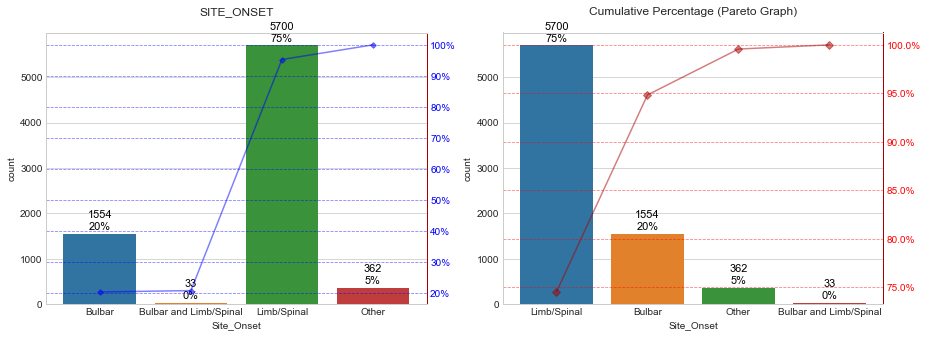

In [54]:
utils.plot_histogram_and_boxplot(series=df.Site_Onset, bins=30, check_normality=False)

----
----
----
## Create the `Age_at_Onset` column
### Calculation based on difference between `Age` (at trial entrance) and `Symptoms_Onset_Delta` column

In [55]:
# crete column with default values
df['Age_at_Onset'] = np.NaN


# get only rows with values in Age and Symptoms_Onset_Delta columns
df_calc_age_onset = df.loc[(df.Age.isnull()==False) & (df.Symptoms_Onset_Delta.isnull()==False)].copy()
print(f'Rows = {utils.get_quantity_of_rows(df_calc_age_onset)}')


# calculate the age at symptoms onset
ages_calculated = df_calc_age_onset.apply( 
    lambda x: utils.calculate_age_from_onset_delta(
        x['Age'], 
        x['Symptoms_Onset_Delta']), 
    axis=1
) 

#update samples with the calculated Age_at_Onset
df.loc[df_calc_age_onset.index,'Age_at_Onset'] = ages_calculated


df[['Age', 'Symptoms_Onset_Delta', 'Age_at_Onset']]



Rows = 7547


,Age,Symptoms_Onset_Delta,Age_at_Onset
0,38.0,-1706.0,34.0
1,52.0,-501.0,51.0
2,65.0,-1023.0,63.0
3,63.0,-715.0,61.0
4,48.0,-341.0,47.0
...,...,...,...
7707,63.0,-426.0,62.0
7708,67.0,-651.0,66.0
7709,59.0,-838.0,57.0
7710,49.0,-155.0,49.0


----
----
----
## Define  a new AGE_RANGE column (grouping samples by ranges of years old)
## based on `Age_at_Onset` and `Age_at_Diagnosis` columns

In [56]:
#define a dictionary with age ranges
age_ranges = {
    '0-39' : [0, 39],
    '40-49': [40, 49],
    '50-59': [50, 59],
    '60-69': [60, 69],
    '70+'  : [70, 999],
}

age_ranges_codes = {
    '0-39' : 0,
    '40-49': 1,
    '50-59': 2,
    '60-69': 3,
    '70+'  : 4,
}

age_ranges.keys()

dict_keys(['0-39', '40-49', '50-59', '60-69', '70+'])

### Create _Age_Range_at_Onset_ and _Age_Range_at_Onset_Coded_ columns

In [57]:
#create Age_Range column and set its value

df_temp = df

df_temp['Age_Range_at_Onset'] = np.NAN

for key, value in age_ranges.items():
    label = key
    min_age = value[0]
    max_age = value[1] + 1
    indices = df_temp[(df_temp['Age_at_Onset'] >= min_age) & (df_temp['Age_at_Onset'] < max_age)]
    df_temp.loc[indices.index, 'Age_Range_at_Onset'] = label
    df_temp.loc[indices.index, 'Age_Range_at_Onset_Coded'] = age_ranges_codes.get(key)


df = df_temp
df


,subject_id,Age,Sex,Qty_Measurements_ALSFRS,Qty_Measurements_VITALSIGNS,Qty_Measurements_FVC,Qty_Measurements_SVC,Qty_Measurements_LABS,Qty_Measurements_HANDGRIPSTRENGTH,Qty_Measurements_MUSCLESTRENGTH,...,Symptoms_Onset_Delta,Diagnosis_Delta,Site_Onset,Diagnosis_Delay_in_Days,Diagnosis_Delay,Diagnosis_Delay_Str,Diagnosis_Delay_Coded,Age_at_Onset,Age_Range_at_Onset,Age_Range_at_Onset_Coded
0,329,38.0,Female,12.0,13.0,8.0,0.0,465.0,0.0,0.0,...,-1706.0,-1068.0,Limb/Spinal,638.0,21.0,Slow,0.0,34.0,0-39,0.0
1,348,52.0,Female,15.0,10.0,0.0,9.0,820.0,0.0,0.0,...,-501.0,-302.0,Other,199.0,6.0,Rapid,2.0,51.0,50-59,2.0
2,533,65.0,Female,6.0,10.0,2.0,6.0,126.0,0.0,0.0,...,-1023.0,-44.0,Bulbar,979.0,32.0,Slow,0.0,63.0,60-69,3.0
3,586,63.0,Male,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,-715.0,-507.0,Bulbar,208.0,6.0,Rapid,2.0,61.0,60-69,3.0
4,649,48.0,Female,12.0,12.0,12.0,0.0,420.0,0.0,0.0,...,-341.0,NaN,Bulbar,NaN,NaN,NaN,NaN,47.0,40-49,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7707,22564,63.0,Male,7.0,0.0,0.0,7.0,376.0,14.0,201.0,...,-426.0,-67.0,Limb/Spinal,359.0,11.0,Average,1.0,62.0,60-69,3.0
7708,160135,67.0,Female,7.0,0.0,0.0,6.0,365.0,14.0,189.0,...,-651.0,-125.0,Bulbar,526.0,17.0,Average,1.0,66.0,60-69,3.0
7709,304192,59.0,Female,7.0,0.0,0.0,7.0,365.0,14.0,168.0,...,-838.0,-351.0,Limb/Spinal,487.0,16.0,Average,1.0,57.0,50-59,2.0
7710,820199,49.0,Male,7.0,0.0,0.0,7.0,363.0,14.0,173.0,...,-155.0,-35.0,Limb/Spinal,120.0,4.0,Rapid,2.0,49.0,40-49,1.0


Column: Age_Range_at_Onset  (DataType: object)
N         = 7547 [Non-NaN: 7547]
Missingness: 165 (2.14%)

Summary Table:
       count percentage
50-59   2378     31.51%
60-69   2077     27.52%
40-49   1549     20.52%
0-39     884     11.71%
70+      659      8.73%


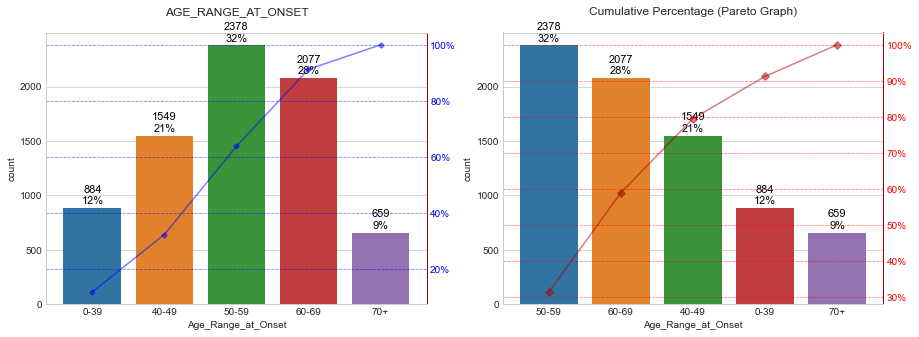

Column: Age_Range_at_Onset_Coded  (DataType: float64)
N         = 7547 [Non-NaN: 7547]
Missingness: 165 (2.14%)
Min       = 0.00  
Max       = 4.00  
SE / Std  = 1.14  (Standard Error or Std.Dev.)
SEM       = 0.01  (Standard Error of the Mean) [Formula: Std.Dev/sqrt(N) => 1.14/sqrt(7547)] 
Mean      = 2.01 +/- 1.14 (Std.Dev.) [Precision of the Mean = 2.01 +/- 0.01 (SEM)] 
Median    = 2.00  
Mode      = 2.0
Variance  = 1.30 (Coefficient of Variation = 0.57)
Skewness  = -0.14 (Left-Skewed) (Approximately Symmetric) 
Kurtosis  = -0.77 (platykurtic, rounded appearance)(PS: a high kurtosis indicates too many outliers) 
Quartiles = [Q1: 25% < 1.00]   [Q2: 50% < 2.00]   [Q3: 75% < 3.00]
 -IQR     = 2.000 (Interquartile Range: IQR = Q3-Q1)
 -Outliers Threshold (IQR * +/-1.5):  [Lower = 0.000]   [Upper = 4.000]


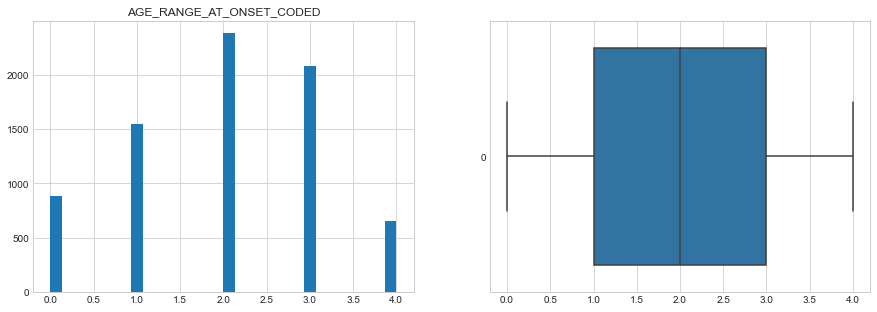

In [58]:
utils.plot_histogram_and_boxplot(df=df, column='Age_Range_at_Onset')
utils.plot_histogram_and_boxplot(df=df, column='Age_Range_at_Onset_Coded')

----
----
----
# Drop some irrelevant columns 

In [59]:
irrelevant_cols = [
    'Site_of_Onset___Bulbar', 
    'Site_of_Onset___Limb', 
    'Site_of_Onset___Limb_and_Bulbar', 
    'Site_of_Onset___Other', 
    'Site_of_Onset___Other_Specify', 
    'Site_of_Onset___Spine', 
    'Subject_ALS_History_Delta',
    'Disease_Duration', 
    'Symptom',
    'Symptom_Other_Specify', 
    'Location', 
    'Location_Other_Specify', 
    'Site_of_Onset',
    'Age',
]


df.drop(
    columns=irrelevant_cols, 
    inplace=True,
)

In [60]:
utils.show_columns_stats(df=df)

subject_id....................... =  7712 rows (100.0%)     0 with NaN (  0.0%) Uniques=  7712 
Sex.............................. =  7712 rows (100.0%)     0 with NaN (  0.0%) Uniques=     2 
Qty_Measurements_ALSFRS.......... =  7712 rows (100.0%)     0 with NaN (  0.0%) Uniques=    32 
Qty_Measurements_VITALSIGNS...... =  7712 rows (100.0%)     0 with NaN (  0.0%) Uniques=    55 
Qty_Measurements_FVC............. =  7712 rows (100.0%)     0 with NaN (  0.0%) Uniques=    20 
Qty_Measurements_SVC............. =  7712 rows (100.0%)     0 with NaN (  0.0%) Uniques=    17 
Qty_Measurements_LABS............ =  7712 rows (100.0%)     0 with NaN (  0.0%) Uniques=   995 
Qty_Measurements_HANDGRIPSTRENGTH =  7712 rows (100.0%)     0 with NaN (  0.0%) Uniques=    38 
Qty_Measurements_MUSCLESTRENGTH.. =  7712 rows (100.0%)     0 with NaN (  0.0%) Uniques=   293 
Qty_Measurements................. =  7712 rows (100.0%)     0 with NaN (  0.0%) Uniques=  1135 
Symptoms_Onset_Delta............. =  754

----
----
----
## DELETE samples having NaN values in the foloowing columns
 - #### `Age_at_Onset   : Previous=9598, To delete=1845, After=7753`
 - #### `Diagnosis_Delay: Previous=7753, To delete=2430, After=5323`
 - #### `Site_Onset     : Previous=5323, To delete=  52, After=5271`

In [61]:
# Age_of_Onset
to_delete = df.loc[(df.Age_at_Onset.isnull())]
df = utils.remove_rows(df=df, to_delete=to_delete)

# Diagnosis_Delay
to_delete = df.loc[(df.Diagnosis_Delay.isnull())]
df = utils.remove_rows(df=df, to_delete=to_delete)

# Site_Onset
to_delete = df.loc[(df.Site_Onset.isnull())]
df = utils.remove_rows(df=df, to_delete=to_delete)

  - Previous=7712, To delete=165, After=7547
  - Previous=7547, To delete=2265, After=5282
  - Previous=5282, To delete=52, After=5230


In [62]:
utils.show_columns_stats(df=df)

subject_id....................... =  5230 rows (100.0%)     0 with NaN (  0.0%) Uniques=  5230 
Sex.............................. =  5230 rows (100.0%)     0 with NaN (  0.0%) Uniques=     2 
Qty_Measurements_ALSFRS.......... =  5230 rows (100.0%)     0 with NaN (  0.0%) Uniques=    32 
Qty_Measurements_VITALSIGNS...... =  5230 rows (100.0%)     0 with NaN (  0.0%) Uniques=    55 
Qty_Measurements_FVC............. =  5230 rows (100.0%)     0 with NaN (  0.0%) Uniques=    20 
Qty_Measurements_SVC............. =  5230 rows (100.0%)     0 with NaN (  0.0%) Uniques=    17 
Qty_Measurements_LABS............ =  5230 rows (100.0%)     0 with NaN (  0.0%) Uniques=   953 
Qty_Measurements_HANDGRIPSTRENGTH =  5230 rows (100.0%)     0 with NaN (  0.0%) Uniques=    38 
Qty_Measurements_MUSCLESTRENGTH.. =  5230 rows (100.0%)     0 with NaN (  0.0%) Uniques=   293 
Qty_Measurements................. =  5230 rows (100.0%)     0 with NaN (  0.0%) Uniques=  1087 
Symptoms_Onset_Delta............. =  523

----
----
----
# Drop unnecessary columns

In [63]:
irrelevant_cols = [
    'Diagnosis_Delay_in_Days', 
]

df.drop(
    columns=irrelevant_cols, 
    inplace=True,
)


----
----
----
# Save the pre-processed data to CSV file

In [64]:
dir_dest = os.path.abspath('../03_proact_preprocessed/')
csv_dest = f'{dir_dest}/_patient.csv'
utils.save_to_csv(df=df, csv_file=csv_dest, with_index=False)


5230 samples were saved


---
---
---
# OTHER TESTS